**Satellite Image Classification with Convolutional Neural Networks**

by Madelyn Silveira, Zivanai Mutaya, James Chillery

April 2025

For this project, we will use the Functional Map of the World dataset, created by the Intelligence Advanced Research Projects Activity (IARPA). We download it from their github: https://github.com/fMoW/dataset.

@inproceedings{fmow2018,
  title={Functional Map of the World},
  author={Christie, Gordon and Fendley, Neil and Wilson, James and Mukherjee, Ryan},
  booktitle={CVPR},
  year={2018}
}

The full dataset contains terabytes of multi-channel data. We will use a simplified version with only rgb channels. Since this simplified version is still around 200GB -- exceeding the storage of collab -- we will stream the data from AWS S3, filtering for relevant classes as we go. We chose target classes that we thought might be useful to characterize energy consumption since 2002.

In [1]:
# this names all classes in the dataset
all_classes = ["airport", "airport_hangar", "airport_terminal", "amusement_park", "aquaculture", "archaeological_site", "barn", "border_checkpoint", "burial_site", "car_dealership", "construction_site", "crop_field", "dam", "debris_or_rubble", "educational_institution", "electric_substation", "factory_or_powerplant", "fire_station", "flooded_road", "fountain", "gas_station", "golf_course", "ground_transportation_station", "helipad", "hospital", "impoverished_settlement", "interchange", "lake_or_pond", "lighthouse", "military_facility", "multi-unit_residential", "nuclear_powerplant", "office_building", "oil_or_gas_facility", "park", "parking_lot_or_garage", "place_of_worship", "police_station", "port", "prison", "race_track", "railway_bridge", "recreational_facility", "road_bridge", "runway", "shipyard", "shopping_mall", "single-unit_residential", "smokestack", "solar_farm", "space_facility", "stadium", "storage_tank", "surface_mine", "swimming_pool", "toll_booth", "tower", "tunnel_opening", "waste_disposal", "water_treatment_facility", "wind_farm", "zoo"]

# these are the classes we want to explore for this project
target_classes = ["electric_substation", "factory_or_powerplant", "gas_station","nuclear_powerplant", "oil_or_gas_facility", "solar_farm", "space_facility", "waste_disposal", "water_treatment_facility", "wind_farm"]

# examples are labeled with the numerical value for each class
target_ids = []
print("Target Classes:\n")
for target_class in target_classes:
    try:
        idx = all_classes.index(target_class)
        target_ids.append(idx)
        print(f"{idx}: {target_class}")
    except ValueError:
        print(f"{target_class} not found in all_classes")

print(f"\nLength: {len(target_ids)}")

for idx, c in enumerate(all_classes):
    print(f"{idx}: {c}")

Target Classes:

15: electric_substation
16: factory_or_powerplant
20: gas_station
31: nuclear_powerplant
33: oil_or_gas_facility
49: solar_farm
50: space_facility
58: waste_disposal
59: water_treatment_facility
60: wind_farm

Length: 10
0: airport
1: airport_hangar
2: airport_terminal
3: amusement_park
4: aquaculture
5: archaeological_site
6: barn
7: border_checkpoint
8: burial_site
9: car_dealership
10: construction_site
11: crop_field
12: dam
13: debris_or_rubble
14: educational_institution
15: electric_substation
16: factory_or_powerplant
17: fire_station
18: flooded_road
19: fountain
20: gas_station
21: golf_course
22: ground_transportation_station
23: helipad
24: hospital
25: impoverished_settlement
26: interchange
27: lake_or_pond
28: lighthouse
29: military_facility
30: multi-unit_residential
31: nuclear_powerplant
32: office_building
33: oil_or_gas_facility
34: park
35: parking_lot_or_garage
36: place_of_worship
37: police_station
38: port
39: prison
40: race_track
41: railway

In [2]:
!pip3 install boto3

  Using cached jmespath-1.0.1-py3-none-any.whl.metadata (7.6 kB)
  Using cached urllib3-2.4.0-py3-none-any.whl.metadata (6.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 2.8 MB/s eta 0:00:0000:0100:01
Using cached jmespath-1.0.1-py3-none-any.whl (20 kB)
Using cached urllib3-2.4.0-py3-none-any.whl (128 kB)


In [3]:
import boto3
import bz2
import json
import pprint

from botocore import UNSIGNED
from botocore.config import Config

# using Amazon Single Storage Service with a guest account
s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
bucket_name = 'spacenet-dataset'
prefix = 'Hosted-Datasets/fmow/fmow-rgb/'

# view the README.md from the S3 bucket
s3.download_file(bucket_name, prefix + 'README.md', 'README.md')
with open('README.md', 'r') as f:
    print(f.read())

# Functional Map of the World (fMoW) RGB Dataset
The data in this bucket represents the JPEG-compressed RGB version of the dataset that was created for the fMoW Challenge. There is another bucket located at s3://spacenet-dataset/fmow/fmow-full that contains the same imagery as this bucket except that all imagery is in a less-compressed TIFF format and multispectral imagery contains 4 or 8 channels of information. The fMoW-full dataset is significantly larger in size, but recommended for those of you who would like less compressed imagery and/or intend to utilize multispectral information.

## The Problem
Intelligence analysts, policy makers, and first responders around the world rely on geospatial land use data to inform crucial decisions about global defense and humanitarian activities. Historically, analysts have manually identified and classified geospatial information by comparing and analyzing satellite images, but that process is time consuming and insufficient to support disaste

In [4]:
# download and load the filed directory
s3.download_file(bucket_name, prefix + 'manifest.json.bz2', 'manifest.json.bz2')
with bz2.open('manifest.json.bz2', 'rt') as f:
    manifest = json.load(f)

# view the beginning structure
pprint.pprint(manifest[:20])

['CHANGELOG.md',
 'IARPA-fMoW.pdf',
 'LICENSE',
 'README.md',
 'fMoW-rgb_seqandgt_v1.2.1.torrent',
 'fMoW-rgb_test_v1.0.0.torrent',
 'fMoW-rgb_trainval_v1.0.0.torrent',
 'fMoW-rgb_val_sample_v1.1.0.torrent',
 'groundtruth.tar.bz2',
 'manifest.json.bz2',
 'seq/0000000/0000000_0_msrgb.jpg',
 'seq/0000000/0000000_0_msrgb.json',
 'seq/0000000/0000000_0_rgb.jpg',
 'seq/0000000/0000000_0_rgb.json',
 'seq/0000000/0000000_2_msrgb.jpg',
 'seq/0000000/0000000_2_msrgb.json',
 'seq/0000000/0000000_2_rgb.jpg',
 'seq/0000000/0000000_2_rgb.json',
 'seq/0000000/0000000_4_msrgb.jpg',
 'seq/0000000/0000000_4_msrgb.json']


In [5]:
from collections import defaultdict

# let's check the folder structure of the manifest
folder_counts = defaultdict(int)
for path in manifest:
    if '/' in path:
        folder = path.split('/')[0]
        folder_counts[folder] += 1
    else:
        folder_counts['[root]'] += 1

for folder, count in folder_counts.items():
    print(f"{folder}/ : {count} items")

[root]/ : 11 items
seq/ : 215040 items
test/ : 213892 items
train/ : 1454288 items
val/ : 212162 items


The seq folder contains temporal sequences of photos. It is useful for analyzing things like flooded roads. We will not be using it for our project.

In [6]:
# how are those folders structured?
subfolder_counts = defaultdict(int)
for path in manifest:
    parts = path.split('/')
    if len(parts) > 1:
        subfolder = '/'.join(parts[:2])
        subfolder_counts[subfolder] += 1
for subfolder, count in subfolder_counts.items():
    print(f"{subfolder}/ : {count} items")

seq/0000000/ : 12 items
seq/0000001/ : 52 items
seq/0000002/ : 4 items
seq/0000003/ : 4 items
seq/0000004/ : 4 items
seq/0000005/ : 12 items
seq/0000006/ : 4 items
seq/0000007/ : 12 items
seq/0000008/ : 28 items
seq/0000009/ : 32 items
seq/0000010/ : 8 items
seq/0000011/ : 8 items
seq/0000012/ : 4 items
seq/0000013/ : 8 items
seq/0000014/ : 4 items
seq/0000015/ : 8 items
seq/0000016/ : 4 items
seq/0000017/ : 40 items
seq/0000018/ : 20 items
seq/0000019/ : 4 items
seq/0000020/ : 56 items
seq/0000021/ : 8 items
seq/0000022/ : 8 items
seq/0000023/ : 16 items
seq/0000024/ : 20 items
seq/0000025/ : 4 items
seq/0000026/ : 12 items
seq/0000027/ : 16 items
seq/0000028/ : 40 items
seq/0000029/ : 40 items
seq/0000030/ : 36 items
seq/0000031/ : 8 items
seq/0000032/ : 8 items
seq/0000033/ : 8 items
seq/0000034/ : 4 items
seq/0000035/ : 4 items
seq/0000036/ : 36 items
seq/0000037/ : 36 items
seq/0000038/ : 12 items
seq/0000039/ : 4 items
seq/0000040/ : 8 items
seq/0000041/ : 12 items
seq/0000042/ :

Dowload the training and validation to local machine. Only download folders of classes we need.

In [7]:
# we need to build a list of the folder paths we want.
target_paths = []
for category in target_classes:
    target_paths.append(f"train/{category}/")
    target_paths.append(f"val/{category}/")
print(target_paths)

def matches_target_paths(file_path, target_folders):
    return any(file_path.startswith(folder) for folder in target_folders)

# we can query this function like so
positive_example = 'train/wind_farm/'
negative_example = 'val/tower/'

print(f"Positive: {matches_target_paths(positive_example, target_paths)}")
print(f"Negative: {matches_target_paths(negative_example, target_paths)}")

['train/electric_substation/', 'val/electric_substation/', 'train/factory_or_powerplant/', 'val/factory_or_powerplant/', 'train/gas_station/', 'val/gas_station/', 'train/nuclear_powerplant/', 'val/nuclear_powerplant/', 'train/oil_or_gas_facility/', 'val/oil_or_gas_facility/', 'train/solar_farm/', 'val/solar_farm/', 'train/space_facility/', 'val/space_facility/', 'train/waste_disposal/', 'val/waste_disposal/', 'train/water_treatment_facility/', 'val/water_treatment_facility/', 'train/wind_farm/', 'val/wind_farm/']
Positive: True
Negative: False


The cell below will download train and val to your local machine. Run in terminal with caffeinate -i python SatelliteClassification.ipynb so your computer doesn't interupt the download.

In [17]:
from PIL import Image
import os
import json

# Create a set for faster lookup
manifest_set = set(manifest)

for file_path in manifest:

    # check if this is a file we want
    if matches_target_paths(file_path, target_paths):

        # we only want msrgb for now
        if file_path.endswith('_msrgb.jpg') or \
            file_path.endswith('_msrgb.json'):

            # download the file to correct folder
            local_path = os.path.join('fmow_msrgb_dataset', file_path)
            local_dir = os.path.dirname(local_path)
            if not os.path.exists(local_dir):
                os.makedirs(local_dir, exist_ok=True)
            s3.download_file(bucket_name, prefix + file_path, local_path)

KeyboardInterrupt: 

You can see that the training and validation data have a nice folder structure to make download easy. Unfortunately, the test data does not come with categories attached, but 'groundtruth.tar.bz2' in the manifest contains a mapping file, 'test_gt_mapping.json', which we will use to merge the proper metadata files with the test images and organize them into folders matching the train and val sets.

In [ ]:
# we need to build a list of the folder paths we want.
target_paths = []
for category in target_classes:
    target_paths.append(f"test_gt/{category}/")
print(target_paths)

def matches_target_paths(file_path, target_folders):
    return any(file_path.startswith(folder) for folder in target_folders)

# we can query this function like so
positive_example = 'test_gt/wind_farm/wind_farm_0/wind_farm_0_0_msrgb.json'
negative_example = 'test_gt/tower/tower_0/tower_0_0_msrgb.json'

print(f"Positive: {matches_target_paths(positive_example, target_paths)}")
print(f"Negative: {matches_target_paths(negative_example, target_paths)}")

['test_gt/electric_substation/', 'test_gt/factory_or_powerplant/', 'test_gt/gas_station/', 'test_gt/nuclear_powerplant/', 'test_gt/oil_or_gas_facility/', 'test_gt/solar_farm/', 'test_gt/space_facility/', 'test_gt/waste_disposal/', 'test_gt/water_treatment_facility/', 'test_gt/wind_farm/']
Positive: True
Negative: False


In [15]:
import tarfile

# let's download groundtruth.tar.bz2 to map test images to their categories
groundtruth_key = prefix + 'groundtruth.tar.bz2'
local_groundtruth = 'groundtruth.tar.bz2'
s3.download_file(bucket_name, groundtruth_key, local_groundtruth)
print(f"Downloaded {local_groundtruth} to current directory.")

# extract groundtruth files into 'groundtruth/' folder
with tarfile.open('groundtruth.tar.bz2', 'r:bz2') as tar:
    target_files = 0
    for member in tar:
        # this mapping file will be the last file you need
        if member.name == 'test_gt_mapping.json':
            tar.extract(member, path='groundtruth')
            print(f"Found {target_files} target files and one mapping file. Stopping early.")
            break

        # extract the only test files that also pertain to target class
        if matches_target_paths(member.name, target_paths):
            tar.extract(member, path='groundtruth')
            target_files += 1

Downloaded groundtruth.tar.bz2 to current directory.
Found 13450 target files and one mapping file. Stopping early.


Now we have the full jsons for the test files and the mapping file, which contains has many dicts like this:

{"input": "test_gt/oil_or_gas_facility/oil_or_gas_facility_68", "output": "test/0000045", "box_mapping": [{"input": 71492, "output": 57, "label": "oil_or_gas_facility"}]}

We need to restore the modified test code to the actual labels.

In [34]:
with open('groundtruth/test_gt_mapping.json', 'r') as f:
    mapping_entries = json.load(f)

for entry in mapping_entries[:5]:
    print(f"input: {entry['input']}")
    print(f"output: {entry['output']}")
    print(f"box_mappings: {entry['box_mapping']}")
    print()

input: test_gt/storage_tank/storage_tank_168
output: test/0000002
box_mappings: [{'input': 111185, 'output': 1, 'label': 'storage_tank'}]

input: test_gt/surface_mine/surface_mine_255
output: test/0000022
box_mappings: [{'input': 108593, 'output': 25, 'label': 'surface_mine'}]

input: test_gt/helipad/helipad_120
output: test/0000014
box_mappings: [{'input': 92203, 'output': 16, 'label': 'helipad'}]

input: test_gt/barn/barn_239
output: test/0000016
box_mappings: [{'input': 99002, 'output': 19, 'label': 'barn'}]

input: test_gt/crop_field/crop_field_431
output: test/0000017
box_mappings: [{'input': 60211, 'output': 20, 'label': 'crop_field'}]



Below is from before April 25

In [54]:
from PIL import Image
import os
import json

images = []
msrgb_jsons = []

# Create a set for faster lookup
manifest_set = set(manifest)

for file in manifest[:50]:
    if file.endswith('_msrgb.jpg'):

        # access metadata for this image before downloading
        base = file.replace('_msrgb.jpg', '')
        json_path = base + '_msrgb.json'

        if json_path in manifest_set:

            # Download and load JSON metadata
            json_local = os.path.basename(json_path)
            s3.download_file(bucket_name, prefix + json_path, json_local)
            with open(json_local, 'r') as f:
                metadata = json.load(f)

            # Check that the box ID's contain a target class
            bounding_boxes = metadata.get("bounding_boxes", [])
            for box in bounding_boxes:
                if box["ID"] in target_ids:

                    print(f"Target class found in {json_local}")
                    break
            else:
                print(f"No target class found in {json_local}")
                continue
            msrgb_jsons.append(metadata)

            # Download image
            print(f"Downloading {file}")
            img_local = os.path.basename(file)
            s3.download_file(bucket_name, prefix + file, img_local)
            img = Image.open(img_local).convert("RGB")
            images.append(img)

        else:
            print(f"No metadata found for {file}")

# print("Loaded MSRGB images:", len(images))
# print("Parsed MSRGB JSONs:", len(msrgb_jsons))


Target class found in 0000000_0_msrgb.json
Target class found in 0000000_2_msrgb.json
Target class found in 0000000_4_msrgb.json
No target class found in 0000001_0_msrgb.json
No target class found in 0000001_10_msrgb.json
No target class found in 0000001_12_msrgb.json
No target class found in 0000001_13_msrgb.json
No target class found in 0000001_1_msrgb.json
No target class found in 0000001_2_msrgb.json
No target class found in 0000001_3_msrgb.json


In [39]:
with open('/content/0000000_0_msrgb.json', 'r') as f:
    metadata = json.load(f)
pprint.pprint(metadata)

{'approximate_wavelengths': [661, 545, 477],
 'bounding_boxes': [{'ID': 15, 'box': [50, 51, 110, 72]}],
 'cloud_cover': 0,
 'country_code': 'MKD',
 'gsd': 2.034444443564688,
 'img_filename': '0000000_0_msrgb.jpg',
 'img_height': 175,
 'img_width': 235,
 'mean_pixel_height': 0.0029355534495564993,
 'mean_pixel_width': -0.009029968274772223,
 'multi_resolution_dbl': 2.036173787693729,
 'multi_resolution_end_dbl': 1.9699947055899163,
 'multi_resolution_max_dbl': 2.151532748299362,
 'multi_resolution_min_dbl': 1.9693469304102431,
 'multi_resolution_start_dbl': 2.150123994849917,
 'off_nadir_angle_dbl': 18.672591392482342,
 'off_nadir_angle_end_dbl': 15.434535015000261,
 'off_nadir_angle_max_dbl': 22.81813189598023,
 'off_nadir_angle_min_dbl': 14.635545482094782,
 'off_nadir_angle_start_dbl': 22.150585288504114,
 'pan_resolution_dbl': 0.5121493420323122,
 'pan_resolution_end_dbl': 0.49485258215932,
 'pan_resolution_max_dbl': 0.5309701412002765,
 'pan_resolution_min_dbl': 0.49862984580064534

Each example has 4 files: the multispectral rgb jpeg and associated json as well as the regular rgb and associated json. We will start with one version and compare with the other if time allows. For now, let's look at the difference.

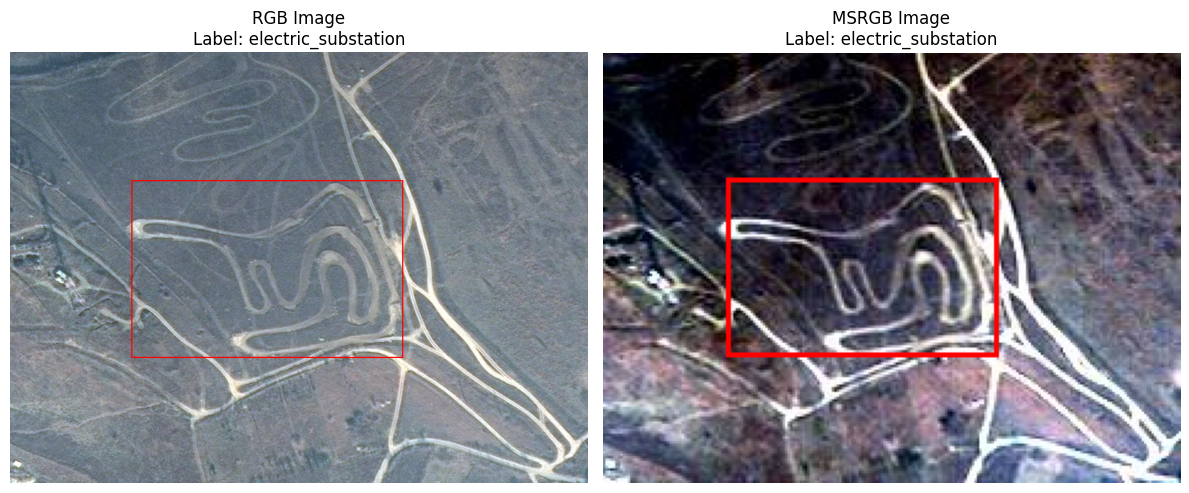

In [73]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

def load_img(img_path, json_path):

    # load the image and metadata
    img_local = os.path.basename(img_path)
    s3.download_file(bucket_name, prefix + img_path, img_local)
    img = Image.open(img_local).convert("RGB")
    json_local = os.path.basename(json_path)
    s3.download_file(bucket_name, prefix + json_path, json_local)
    with open(json_local, 'r') as f:
        metadata = json.load(f)

    # each image has bounding boxes to indicate class instances
    draw = ImageDraw.Draw(img)
    ids = []
    for box in metadata.get("bounding_boxes", []):

        # get the label for this id
        try:
            ids.append(all_classes[box["ID"]])
        except ValueError:
            ids.append("unkown")

        # draw the box within the image
        x_min, y_min, width, height = box["box"]
        draw.rectangle([x_min, y_min, x_min + width, y_min + height], outline="red", width=2)

    return img, ids

# load both spectral versions and their annotations
img_rgb, ids_rgb = load_img("seq/0000000/0000000_0_rgb.jpg", "seq/0000000/0000000_0_rgb.json")
img_msrgb, ids_msrgb = load_img("seq/0000000/0000000_0_msrgb.jpg", "seq/0000000/0000000_0_msrgb.json")

# plot them side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img_rgb)
axes[0].set_title(f"RGB Image\nLabel: {ids_rgb[0]}")
axes[0].axis('off')
axes[1].imshow(img_msrgb)
axes[1].set_title(f"MSRGB Image\nLabel: {ids_msrgb[0]}")
axes[1].axis('off')
plt.tight_layout()
plt.show()

Notice how the bounding box in the multispectral image is thicker. This is because the "width" attribute is pixel-dependent, and the msrgb images are scaled down to maintain picture integrity at a lower resolution.

In [ ]:
# compare the image sizes
print("RGB size:", img_rgb.size)
print("MSRGB size:", img_msrgb.size)

We will train models on the msrgb pictures to start, and compare with rgb data if time allows. We will also crop bounding bozes as we stream, to eliminate storing extra image data. Although this is not neccessary for the amount of data we are actually holding, it will be good to maintain consistent practices as we scale up our dataset.

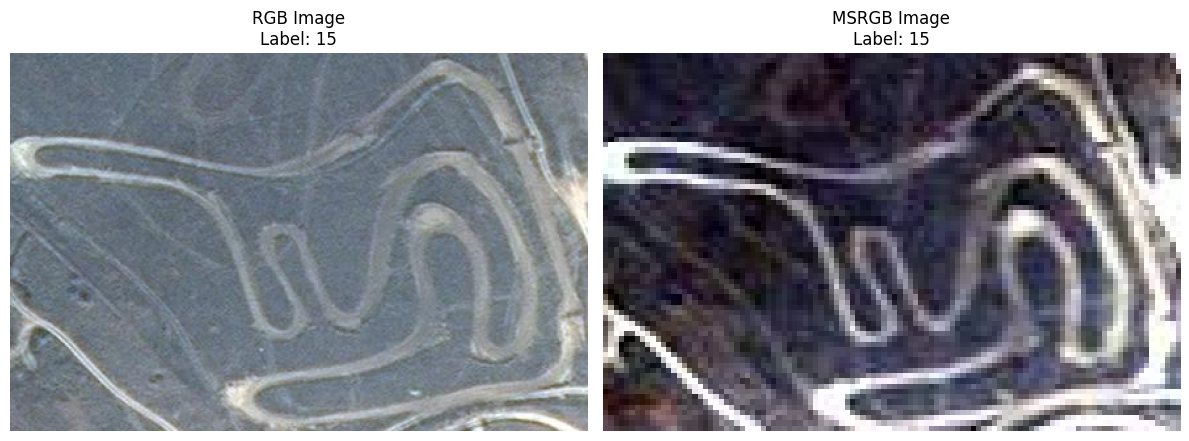

In [64]:
def load_and_crop(img_path, json_path, save_dir=None):

    # load the image and metadata
    img_local = os.path.basename(img_path)
    s3.download_file(bucket_name, prefix + img_path, img_local)
    img = Image.open(img_local).convert("RGB")
    json_local = os.path.basename(json_path)
    s3.download_file(bucket_name, prefix + json_path, json_local)
    with open(json_local, 'r') as f:
        metadata = json.load(f)

    crops = []
    labels = []
    for i, box in enumerate(metadata.get("bounding_boxes", [])):
        label = box["ID"]
        x_min, y_min, width, height = box['box']
        cropped = img.crop((x_min, y_min, x_min + width, y_min + height))
        crops.append(cropped)
        labels.append(label)

    return crops, labels


# load both spectral versions and their annotations
img_rgb, ids_rgb = load_and_crop("seq/0000000/0000000_0_rgb.jpg", "seq/0000000/0000000_0_rgb.json")
img_msrgb, ids_msrgb = load_and_crop("seq/0000000/0000000_0_msrgb.jpg", "seq/0000000/0000000_0_msrgb.json")

# plot them side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img_rgb[0])
axes[0].set_title(f"RGB Image\nLabel: {ids_rgb[0]}")
axes[0].axis('off')
axes[1].imshow(img_msrgb[0])
axes[1].set_title(f"MSRGB Image\nLabel: {ids_msrgb[0]}")
axes[1].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# First download the JSON file from S3
json_key = 'Hosted-Datasets/fmow/fmow-rgb/seq/0000000/0000000_0_msrgb.json'
s3.download_file('spacenet-dataset', json_key, '0000000_0_msrgb.json')

# Now open it
import json
with open('0000002_0_rgb.json', 'r') as f:
    metadata = json.load(f)

# Inspect
import pprint
pprint.pprint(metadata)

# Try to access the label (structure may vary)
try:
    print(metadata.get('bounding_boxes')[0]['ID'])
except AttributeError:
    print("No bounding boxes found")


We will have to go through each element (which includes a json, jpg, and possibly multiple versions of the same image), download the json, go through each element in the bounding boxes attribute, and check if that ID is in our target ID. If it is not, we can remove that bounding box from the image.

In [ ]:
# First download the JSON file from S3
json_key = 'Hosted-Datasets/fmow/fmow-rgb/seq/0000002/0000002_0_rgb.json'
s3.download_file('spacenet-dataset', json_key, '0000002_0_rgb.json')

# Now open it
import json
with open('0000002_0_rgb.json', 'r') as f:
    metadata = json.load(f)

# Inspect
import pprint
pprint.pprint(metadata)

# Try to access the label (structure may vary)
try:
    print(metadata.get('bounding_boxes')[0]['ID'])
except AttributeError:
    print("No bounding boxes found")


{'approximate_wavelengths': [661, 545, 477],
 'bounding_boxes': [{'ID': 34, 'box': [363, 202, 176, 130]}],
 'cloud_cover': 0,
 'country_code': 'DEU',
 'gsd': 0.5673482110730339,
 'img_filename': '0000002_0_rgb.jpg',
 'img_height': 548,
 'img_width': 872,
 'mean_pixel_height': 0.006779125954233597,
 'mean_pixel_width': -0.0024696584369609483,
 'multi_resolution_dbl': 2.2632873733159293,
 'multi_resolution_end_dbl': 2.163422292909159,
 'multi_resolution_max_dbl': 2.3894950186945025,
 'multi_resolution_min_dbl': 2.174041214724693,
 'multi_resolution_start_dbl': 2.3817187801994457,
 'off_nadir_angle_dbl': 31.4575077233461,
 'off_nadir_angle_end_dbl': 30.287138393053638,
 'off_nadir_angle_max_dbl': 35.0517405090433,
 'off_nadir_angle_min_dbl': 28.86995617019709,
 'off_nadir_angle_start_dbl': 33.64834431361248,
 'pan_resolution_dbl': 0.5581039230855221,
 'pan_resolution_end_dbl': 0.5430218873075267,
 'pan_resolution_max_dbl': 0.5897686532679226,
 'pan_resolution_min_dbl': 0.5386199503446387,

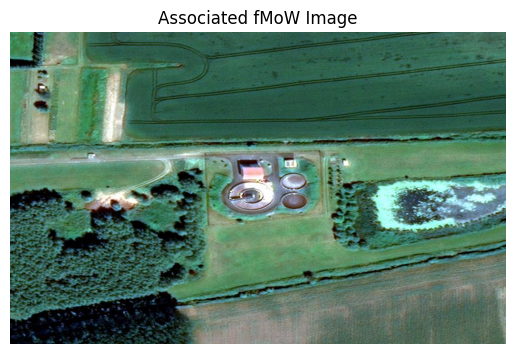

In [ ]:
img_key = 'Hosted-Datasets/fmow/fmow-rgb/seq/0000002/0000002_0_rgb.jpg'
s3.download_file('spacenet-dataset', img_key, '0000002_0_rgb.jpg')

from PIL import Image
import matplotlib.pyplot as plt

img = Image.open('0000002_0_rgb.jpg')
plt.imshow(img)
plt.axis('off')
plt.title("Associated fMoW Image")
plt.show()

In [ ]:
entry = manifest[10]
print(entry['json_path'])  # e.g., 'seq/0000000/0000000_0_msrgb.json'
print(entry['label'])      # e.g., 'hospital'


TypeError: string indices must be integers, not 'str'

In [ ]:
# the classes we are interested in
target_classes = {"factory or powerplant", "nuclear powerplant", "oil or gas facility", "smokestack", "solar farm", "space facility", "waste disposal", "water treatment facility", "wind farm", "electric substation", "gas station"}

In [ ]:
filtered_images = [entry for entry in manifest if entry["label"] in target_classes]
print(f"Found {len(filtered_images)} images in your target classes.")

In [ ]:
import os

os.makedirs("images", exist_ok=True)

# Download the first few filtered images as a test
for entry in filtered_images[:20]:  # ⬅️ limit here for Colab
    image_key = prefix + entry["image"]  # e.g. Hosted-Datasets/fmow/fmow-rgb/images/train/000017.tif
    local_path = f"images/{entry['id']}.tif"

    print(f"Downloading {entry['label']} → {local_path}")
    s3.download_file(bucket_name, image_key, local_path)


In [ ]:
print(type(manifest))
manifest

<class 'list'>


['CHANGELOG.md',
 'IARPA-fMoW.pdf',
 'LICENSE',
 'README.md',
 'fMoW-rgb_seqandgt_v1.2.1.torrent',
 'fMoW-rgb_test_v1.0.0.torrent',
 'fMoW-rgb_trainval_v1.0.0.torrent',
 'fMoW-rgb_val_sample_v1.1.0.torrent',
 'groundtruth.tar.bz2',
 'manifest.json.bz2',
 'seq/0000000/0000000_0_msrgb.jpg',
 'seq/0000000/0000000_0_msrgb.json',
 'seq/0000000/0000000_0_rgb.jpg',
 'seq/0000000/0000000_0_rgb.json',
 'seq/0000000/0000000_2_msrgb.jpg',
 'seq/0000000/0000000_2_msrgb.json',
 'seq/0000000/0000000_2_rgb.jpg',
 'seq/0000000/0000000_2_rgb.json',
 'seq/0000000/0000000_4_msrgb.jpg',
 'seq/0000000/0000000_4_msrgb.json',
 'seq/0000000/0000000_4_rgb.jpg',
 'seq/0000000/0000000_4_rgb.json',
 'seq/0000001/0000001_0_msrgb.jpg',
 'seq/0000001/0000001_0_msrgb.json',
 'seq/0000001/0000001_0_rgb.jpg',
 'seq/0000001/0000001_0_rgb.json',
 'seq/0000001/0000001_10_msrgb.jpg',
 'seq/0000001/0000001_10_msrgb.json',
 'seq/0000001/0000001_10_rgb.jpg',
 'seq/0000001/0000001_10_rgb.json',
 'seq/0000001/0000001_12_msrgb.j

In [ ]:
filtered_images = [entry for entry in manifest if entry["label"] in target_classes]
print(f"Found {len(filtered_images)} images in your target classes.")

TypeError: string indices must be integers, not 'str'